In [ ]:
%pip install tensorflow==2.13.0 pandas==2.3.3 matplotlib numpy==1.24.3

In [ ]:
%pip install gensim

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [19]:
warnings.filterwarnings("ignore")

In [20]:
print(tf.__version__)

2.13.0


In [21]:
BATCH_SIZE = 64  # Number of examples used in each iteration
EPOCHS = 100  # Number of passes through entire dataset
MAX_LEN = 100  # Max length of review (in words)
EMBEDDING = 100  # Dimension of word embedding vector

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# data = pd.read_csv("/kaggle/input/dataset-pos-pidana-baru/DatasetPos-Pidana200.csv", encoding="latin1")
data = pd.read_csv("PN-PKL-230411100087.csv", encoding="latin1")
# data = pd.read_csv("/kaggle/input/dataset-pidana-baru/Dataset-Pidana200 (1).csv")

# data['word'] = data['word'].str.lower()
data['word'] = data['word'].replace(to_replace ='\d+', value = '<\g<0>>', regex = True).replace(to_replace ='[0-9]', value = 'X', regex = True)
data = data.fillna(method="ffill")

In [23]:
data

,doc,sentence,word,prev,next,pos,tag
0,doc:0,sentence: 000001,putusan,.,nomor,NOUN,O
1,doc:0,sentence: 000001,nomor,putusan,14,NOUN,O
2,doc:0,sentence: 000001,<XX>,nomor,/,NUM,B_VERN
3,doc:0,sentence: 000001,pid,/,.,NOUN,I_VERN
4,doc:0,sentence: 000001,sus,.,/,PROPN,I_VERN
...,...,...,...,...,...,...,...
1741414,doc:284,sentence: 048499,panitera,h,pengganti,NOUN,O
1741415,doc:284,sentence: 048499,pengganti,panitera,",",NOUN,O
1741416,doc:284,sentence: 048499,ttd,",",agus,PROPN,O
1741417,doc:284,sentence: 048499,agus,ttd,giharno,NOUN,B_REGI


In [24]:
data.groupby('tag').count()

,doc,sentence,word,prev,next,pos
tag,,,,,,
B_ADVO,234,234,234,234,234,234
B_ARTV,969,969,969,969,969,969
B_CRIA,4301,4301,4301,4301,4301,4301
B_DEFN,2322,2322,2322,2322,2322,2322
B_JUDP,378,378,378,378,378,378
B_JUG,732,732,732,732,732,732
B_PENA,269,269,269,269,269,269
B_PROS,231,231,231,231,231,231
B_PUNI,316,316,316,316,316,316


In [25]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
n_words

17261

In [26]:
tags = list(set(data["tag"].values))
n_tags = len(tags)
n_tags

25

## Group Per Kalimat

In [27]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

# class DocGetter(object):

#     def __init__(self, data):
#         self.n_doc = 1
#         self.data = data
#         self.empty = False
#         agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
#                                                            s["tag"].values.tolist())]
#         self.grouped = self.data.groupby("doc").apply(agg_func)
#         self.docs = [s for s in self.grouped]

#     def get_next(self):
#         try:
#             d = self.grouped[self.n_doc]
#             self.n_doc += 1
#             return d
#         except:
#             return None

In [28]:
# # getter = DocGetter(data)
# # docs = getter.docs
getter = SentenceGetter(data)
sentences = getter.sentences

In [29]:
sentences[500]

[('-bahwa', 'O'),
 ('benar', 'O'),
 ('akibat', 'O'),
 ('k', 'O'),
 ('saksi', 'O'),
 ('korban', 'O'),
 ('nurul', 'O'),
 ('febrianto', 'O'),
 ('menderita', 'O'),
 ('luka', 'O'),
 ('bengkak', 'O'),
 ('mata', 'O'),
 ('kanan', 'O'),
 ('terdapat', 'O'),
 ('pendarahan', 'O'),
 ('memar', 'O'),
 ('sudut', 'O'),
 ('mata', 'O'),
 ('kanan', 'O'),
 ('ukuran', 'O'),
 ('<X>', 'O'),
 ('<X>', 'O'),
 ('cm', 'O'),
 ('memar', 'O'),
 ('paha', 'O'),
 ('kanan', 'O'),
 ('ukuran', 'O'),
 ('<X>', 'O'),
 ('<X>', 'O'),
 ('cm', 'O'),
 ('lecet', 'O'),
 ('kaki', 'O'),
 ('kanan', 'O'),
 ('ukuran', 'O'),
 ('<X>', 'O'),
 ('cm', 'O'),
 ('sebagaimana', 'O'),
 ('visum', 'O'),
 ('et', 'O'),
 ('repertum', 'O'),
 ('nomor', 'O'),
 ('<XX>', 'O'),
 ('ver', 'O'),
 ('vii', 'O'),
 ('<XXXX>', 'O'),
 ('tanggal', 'O'),
 ('<XX>', 'O'),
 ('juli', 'O'),
 ('<XXXX>', 'O'),
 ('dibuat', 'O'),
 ('ditandatangani', 'O'),
 ('dr', 'O'),
 ('salsabila', 'O'),
 ('lukman', 'O'),
 ('makarim', 'O'),
 ('dokter', 'O'),
 ('pemeriksa', 'O'),
 ('rumah', 'O

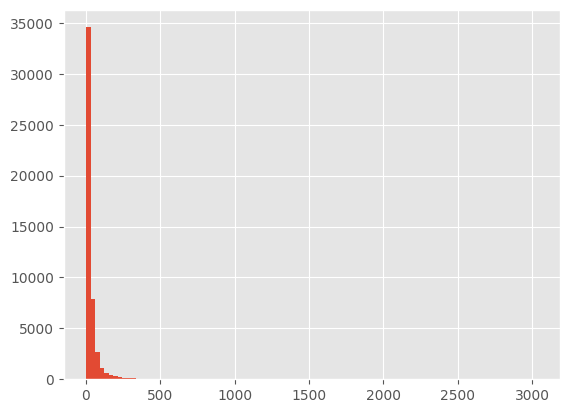

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(s) for s in sentences], bins=100)
plt.show()

# CBOW

In [33]:
from gensim.models import Word2Vec
sentences_words = [[w[0] for w in s] for s in sentences]
cbow_model = Word2Vec(sentences_words, vector_size=10, window=5, min_count=1, sg=0)

In [34]:
tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {i: w for w, i in tag2idx.items()}

In [35]:
def get_word_embedding(word):
    if word in cbow_model.wv:
        return cbow_model.wv[word]
    else:
        return np.zeros(cbow_model.vector_size)

In [41]:
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
X = [[get_word_embedding(w[0]) for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [42]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, shuffle=False)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((38797, 100, 10), (9700, 100, 10), (38797, 100, 26), (9700, 100, 26))

In [43]:
cbow_model.vector_size

10

In [44]:
from keras import Model
from keras import optimizers
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D, Reshape
from keras.utils import plot_model

# input = Input(shape=(MAX_LEN,)) #Asli
input = Input(shape=(MAX_LEN, cbow_model.vector_size))

# model = Embedding(input_dim=n_words, output_dim=10, input_length=5)(input)
model = Dropout(0.1)(input)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 10)]         0         
                                                                 
 dropout (Dropout)           (None, 100, 10)           0         
                                                                 
 bidirectional (Bidirection  (None, 100, 200)          88800     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 26)           5226      
 ributed)                                                        
                                                                 
Total params: 94026 (367.29 KB)
Trainable params: 94026 (367.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
input

<KerasTensor: shape=(None, 100, 10) dtype=float32 (created by layer 'input_1')>

## Visualisasi Model

In [46]:
! pip install pydot graphviz


   -------------------- ------------------- 1/2 [graphviz]
   -------------------- ------------------- 1/2 [graphviz]
   -------------------- ------------------- 1/2 [graphviz]
   ---------------------------------------- 2/2 [graphviz]



In [47]:
from keras.utils import plot_model

plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


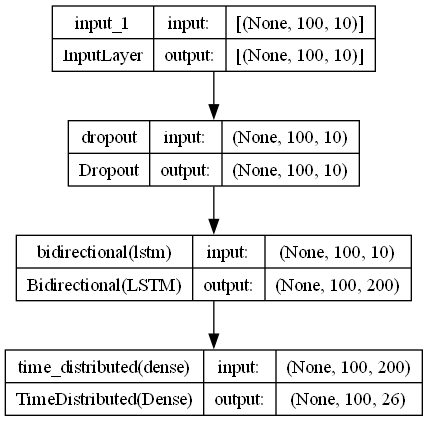

In [48]:


from IPython.display import Image

image_path = 'model_visualization.png'
display(Image(filename=image_path))
with open(image_path, 'rb') as img_file:
    img_data = img_file.read()

In [49]:
history = model.fit(np.array(X_tr).astype(int),
                    np.array(y_tr).astype(int),
                    batch_size=BATCH_SIZE,
                    epochs=100,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100
546/546 [==============================] - 125s 226ms/step - loss: 0.0578 - accuracy: 0.9916 - val_loss: 0.0173 - val_accuracy: 0.9951
Epoch 2/100
546/546 [==============================] - 128s 234ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0144 - val_accuracy: 0.9959
Epoch 3/100
546/546 [==============================] - 137s 251ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0129 - val_accuracy: 0.9962
Epoch 4/100
546/546 [==============================] - 145s 265ms/step - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0121 - val_accuracy: 0.9961
Epoch 5/100
546/546 [==============================] - 149s 274ms/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0121 - val_accuracy: 0.9964
Epoch 6/100
546/546 [==============================] - 150s 276ms/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.0115 - val_accuracy: 0.9966
Epoch 7/100
546/546 [==============================] - 148s 271ms/step - loss: 0.0098 - accuracy: 0.9964 - val_loss: 0

In [51]:
%pip install torch

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
    --------------------------------------- 1.6/109.3 MB 11.9 MB/s eta 0:00:10
   - -------------------------------------- 3.9/109.3 MB 12.4 MB/s eta 0:00:09
   -- ------------------------------------- 6.8/109.3 MB 12.0 MB/s eta 0:00:09
   --- ------------------------------------ 9.4/109.3 MB 12.0 MB/s eta 0:00:09
   ---- ----------------------------------- 11.8/109.3 MB 11.9 MB/s eta 0:00:09
   ----- ---------------------------------- 14.2/109.3 MB 11.9 MB/s eta 0:00:09
   ------ --------------------------------- 16.8/109.3 MB 11.9 MB/s eta 0:00:08
   ------- -------------------------------- 19.1/109.3 MB 11.8 MB/s eta 0:00:08
   ------- -------------------------------- 21.5/109.3 MB 11.9 MB/s eta 0:00:08
   -------- ------------------------------- 24.1/109.3 MB 11.8 MB/s eta 0:00:08
   --------- ------------------------------ 26.7/109.3 MB 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.15.0 which is incompatible.


In [52]:
import torch

In [53]:
path = 'model-BiLSTM-Pidana500-100Epoch-moidf.pth'
torch.save(model, path)

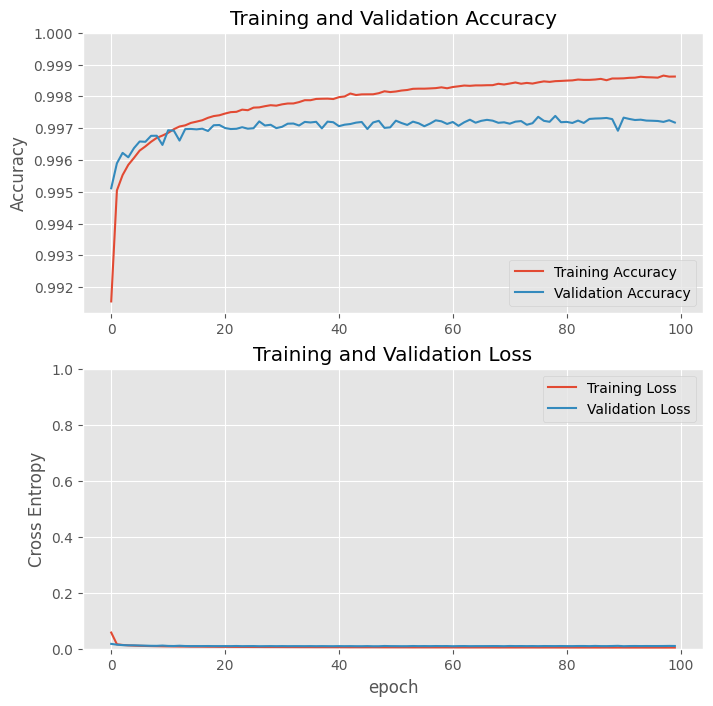

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
eve = model.predict(X_te)

304/304 [==============================] - 9s 27ms/step


In [56]:
y_pred = np.argmax(eve, axis=-1)
y_test_true = np.argmax(y_te, -1)

# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

m = MultiLabelBinarizer().fit(y_test_true)
print("Precision Score: {}".format(precision_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))
print("Recall Score   : {}".format(recall_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))
print("F1-score Score : {}".format(f1_score(m.transform(y_test_true), m.transform(y_pred), average="macro")))

Precision Score: 0.8024205337503035
Recall Score   : 0.8854352585257093
F1-score Score : 0.833551674556052


In [58]:
from sklearn.metrics import classification_report
def c_report(y_pred, y_true):
  # Menggabungkan elemen-elemen array menjadi satu list
  y_pred_flat = [item for sublist in y_pred for item in sublist]
  y_true_flat = [item for sublist in y_true for item in sublist]
  report = classification_report(y_pred_flat, y_true_flat)
  return report

In [59]:
report = c_report(y_pred, y_test_true)
print(report)

              precision    recall  f1-score   support

      B_ADVO       0.84      0.82      0.83        39
      B_ARTV       0.89      0.51      0.65       270
      B_CRIA       0.54      0.61      0.57       668
      B_DEFN       0.63      0.38      0.47       428
      B_JUDP       0.92      0.94      0.93        70
       B_JUG       0.82      0.86      0.84       150
      B_PENA       0.86      0.78      0.82        54
      B_PROS       0.89      0.92      0.90        51
      B_PUNI       0.77      0.77      0.77        73
      B_REGI       0.98      0.83      0.90       121
      B_TIMV       0.98      0.93      0.96        60
      B_VERN       0.93      0.84      0.88       237
      I_ADVO       0.89      0.82      0.86        62
      I_ARTV       0.79      0.56      0.65       682
      I_CRIA       0.37      0.70      0.48        10
      I_DEFN       0.60      0.39      0.47      1887
      I_JUDP       0.93      0.89      0.91       125
       I_JUG       0.92    

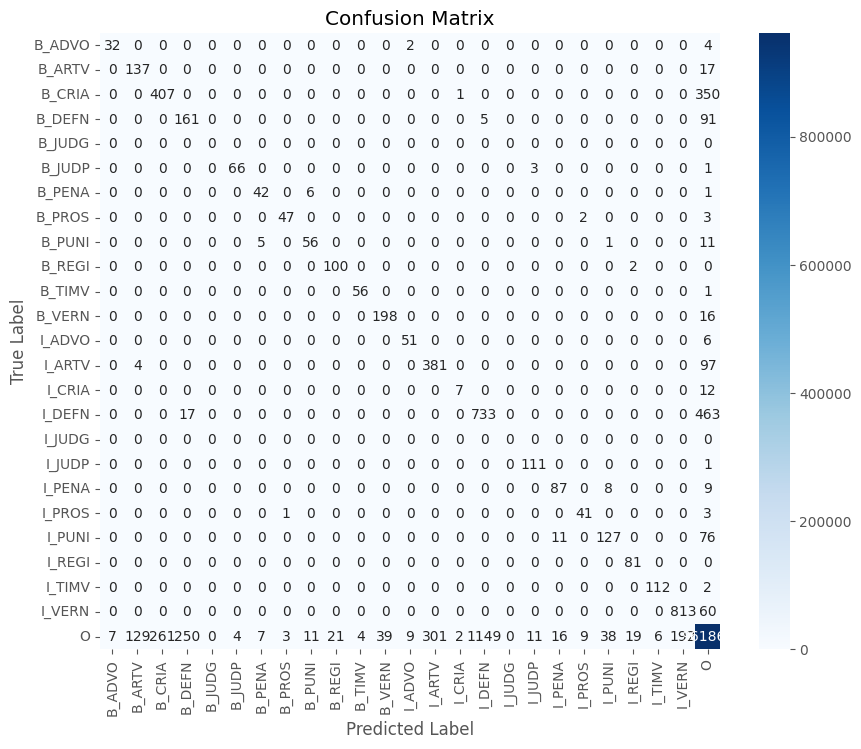

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Definisi class_names (sesuaikan dengan label yang sesuai dalam datasetmu)
class_names = ['B_ADVO', 'B_ARTV', 'B_CRIA', 'B_DEFN', 'B_JUDG', 'B_JUDP', 'B_PENA', 'B_PROS', 'B_PUNI', 'B_REGI', 'B_TIMV', 'B_VERN', 'I_ADVO', 'I_ARTV', 'I_CRIA', 'I_DEFN', 'I_JUDG', 'I_JUDP', 'I_PENA', 'I_PROS', 'I_PUNI', 'I_REGI', 'I_TIMV', 'I_VERN', 'O']

conf_mat = confusion_matrix([item for sublist in y_test_true for item in sublist],
                            [item for sublist in y_pred for item in sublist],
                            labels=class_names)
# Visualisasi confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [64]:
model = torch.load("model-BiLSTM-Pidana500-100Epoch-moidf.pth", weights_only=False)

In [67]:
def prepare_input(words, cbow_model, max_len):
    X = [[get_word_embedding(word) for word in words]]
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", dtype='float32', value=np.zeros(cbow_model.vector_size))
    return np.array(X)

def predict_single_word(model, X_new, cbow_model, max_len, idx2tag):
    y_pred = model.predict(X_new)
    y_pred = np.argmax(y_pred, axis=-1)
    predicted_tag_idx = y_pred[0][0]
    return idx2tag[predicted_tag_idx]

def predict_tags(model, words, cbow_model, max_len, idx2tag):
    X_new = prepare_input(words, cbow_model, max_len)
    y_pred = model.predict(X_new)
    y_pred = np.argmax(y_pred, axis=-1)
    predictions = [idx2tag[idx] for idx in y_pred[0]]
    return predictions

In [69]:
new_word = "pkl"
X_new = prepare_input(new_word, cbow_model, MAX_LEN)
predicted_tag = predict_single_word(model, X_new, cbow_model, MAX_LEN, idx2tag)
 
print(f"The predicted tag for '{new_word}' is '{predicted_tag}'")

1/1 [==============================] - 0s 31ms/step
The predicted tag for 'pkl' is 'O'
